In [14]:
from glob import glob
import pandas as pd
from pingouin import plot_paired, compute_effsize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Read the results generated by OCE.  These were generated by the script oce_model_stats.py

In [15]:
df_list = []
for filename in glob("*RND_stats.csv"):
    df = pd.read_csv(filename)
    df_list.append(df)

Concatenate the OCE results into one dataframe.

In [16]:
oce_df = pd.concat(df_list)

Read the results from previous models on this dataset. Note that this file also contains the cross-validation splits.

In [17]:
cmp_df = pd.read_csv("../comparison.csv")

Define the training and test sets.

In [18]:
oce_df['split'] =[f"RND_{x:02d}" for x in oce_df.cycle]

Merge oce_df and cmp_df

In [19]:
merge_df = oce_df.merge(cmp_df,on=["dataset","split"])

Compare mean RMSE for 10 folds between OCE and GP

In [20]:
mean_list = []
for k,v in merge_df.groupby("dataset"):
    mean_list.append([k,v.rmse.mean(),v.gp_rmse.mean()])
mean_df = pd.DataFrame(mean_list,columns=["Dataset","OCE RMSE Mean","GP RMSE Mean"])
mean_df.round(2)

,Dataset,OCE RMSE Mean,GP RMSE Mean
0,A2a,0.81,0.69
1,ABL1,0.77,0.76
2,Acetylcholinesterase,0.70,0.71
3,Aurora-A,0.80,0.80
4,B-raf,0.63,0.64
5,COX-1,0.69,0.69
6,COX-2,0.75,0.75
7,Cannabinoid,0.71,0.70
8,Carbonic,0.59,0.57
9,Caspase,0.54,0.55


Plot a kde comparing mean RMSE between GP and OCE

<AxesSubplot:xlabel='RMSE', ylabel='Density'>

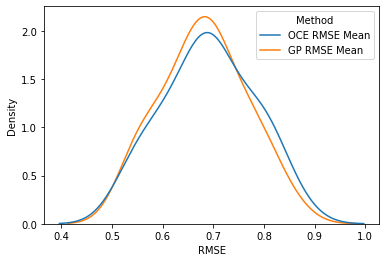

In [21]:
melt_mean_df = mean_df.melt(id_vars="Dataset")
melt_mean_df.columns = ["Dataset","Method","RMSE"]
sns.kdeplot(x="RMSE",hue="Method",data=melt_mean_df)

Calculate the effect size and associated probability

In [22]:
d = compute_effsize(mean_df["OCE RMSE Mean"],mean_df["GP RMSE Mean"],eftype="cohen")
print(f"effect size = {d:.3f}")
print(f"probability = {d*0.25+0.5:.3f}")

effect size = 0.118
probability = 0.530


Look at the merged data

In [23]:
merge_df

,dataset,cycle,r2,rmse,split,gp_r2,xgb_r2,ffnn_r2,gp_rmse,xgb_rmse,ffnn_rmse
0,Acetylcholinesterase,0,0.728311,0.666887,RND_00,0.722437,0.677210,0.685766,0.674057,0.726903,0.717204
1,Acetylcholinesterase,1,0.700129,0.697901,RND_01,0.703873,0.645328,0.630886,0.693531,0.758997,0.774296
2,Acetylcholinesterase,2,0.732367,0.648900,RND_02,0.708440,0.663787,0.654067,0.677285,0.727302,0.737741
3,Acetylcholinesterase,3,0.663850,0.738756,RND_03,0.663667,0.624172,0.634533,0.738957,0.781141,0.770298
4,Acetylcholinesterase,4,0.681520,0.713170,RND_04,0.678037,0.637935,0.620514,0.717058,0.760406,0.778484
...,...,...,...,...,...,...,...,...,...,...,...
235,Glycogen,5,0.632710,0.679024,RND_05,0.645770,0.572355,0.592027,0.666842,0.732693,0.715642
236,Glycogen,6,0.652591,0.687898,RND_06,0.664601,0.641615,0.609411,0.675904,0.698680,0.729396
237,Glycogen,7,0.617736,0.700620,RND_07,0.648895,0.599600,0.596467,0.671459,0.717047,0.719847
238,Glycogen,8,0.630533,0.694454,RND_08,0.613976,0.523340,0.610607,0.709844,0.788787,0.712935


Reformat the data to generate the paired plots

In [24]:
melt_df = merge_df[["dataset","cycle","rmse","gp_rmse"]].melt(id_vars=["dataset","cycle"])
melt_df.head()

,dataset,cycle,variable,value
0,Acetylcholinesterase,0,rmse,0.666887
1,Acetylcholinesterase,1,rmse,0.697901
2,Acetylcholinesterase,2,rmse,0.648900
3,Acetylcholinesterase,3,rmse,0.738756
4,Acetylcholinesterase,4,rmse,0.713170


Rename the fields so that plot makes sense

In [25]:
method_dict = {"rmse" : "OCE", "gp_rmse" : "GP"}
melt_df['variable'] = [method_dict[x] for x in melt_df.variable]

Make the paired plots

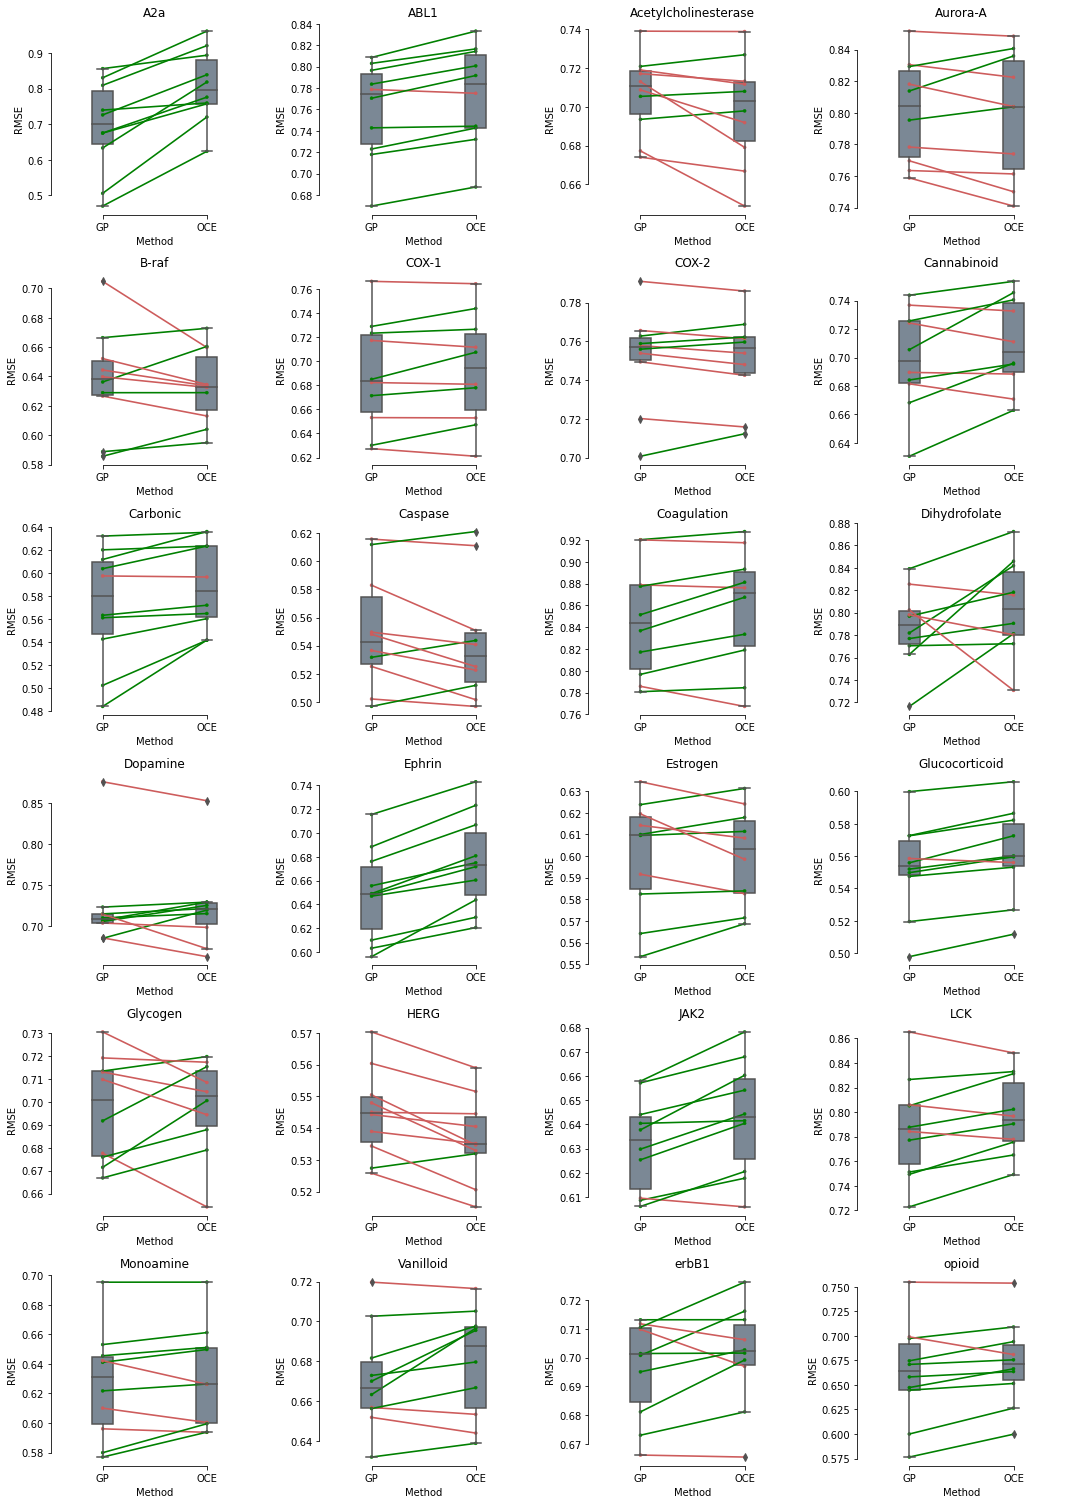

In [26]:
fig, axs = plt.subplots(nrows=6,ncols=4,figsize=(15,21))
for idx,ds in enumerate(sorted(melt_df.dataset.unique())):
    row = idx//4
    col = idx%4
    ax = plot_paired(data=melt_df.query("dataset == @ds"),dv="value",within="variable",subject="cycle",ax=axs[row,col])
    ax.set_title(ds)
    ax.set_ylabel("RMSE")
    ax.set_xlabel("Method")
    plt.tight_layout()